### 0. Import the Libraries

In [1]:
import pickle
from chart_studio import plotly as py
import plotly.tools as tls
from plotly.graph_objs import *
from datetime import datetime
from collections import Counter
import itertools
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import os

from sklearn.model_selection import GridSearchCV
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek

from xgboost import XGBClassifier


## 1. Loading and Preparing Data

### Reading and merge dataset

In [2]:
df_18 = pd.read_csv("./data/Chicago_Crimes_2018.csv")
df_19 = pd.read_csv("./data/Chicago_Crimes_2019.csv")
df_20 = pd.read_csv("./data/Chicago_Crimes_2020.csv")
df_21 = pd.read_csv("./data/Chicago_Crimes_2021.csv")
df_22 = pd.read_csv("./data/Chicago_Crimes_2022.csv")
df_23 = pd.read_csv("./data/Chicago_Crimes_2023.csv")
df_raw = pd.concat([df_18, df_19, df_20, df_21, df_22, df_23], ignore_index=True)

In [3]:
df_raw.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

In [4]:
selected_columns = ['Date', 'Latitude', 'Longitude', 'Primary Type']
df = df_raw[selected_columns]

In [5]:
top_10_type_crimes = df['Primary Type'].value_counts()[:5].index.tolist()
other_type_crimes = df['Primary Type'].value_counts()[5:].index.tolist()

for c in other_type_crimes:
    df.drop(df[df['Primary Type'] == c].index, inplace = True)
print(df['Primary Type'].value_counts())

C:\Users\soumy\AppData\Local\Temp\ipykernel_48176\603065442.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



THEFT                 304173
BATTERY               253476
CRIMINAL DAMAGE       152999
ASSAULT               116361
DECEPTIVE PRACTICE    102493
Name: Primary Type, dtype: int64


In [6]:
df.head()

,Date,Latitude,Longitude,Primary Type
1,09/15/2018 08:00:00 AM,NaN,NaN,DECEPTIVE PRACTICE
2,09/30/2018 01:05:00 PM,41.694643,-87.661565,ASSAULT
4,12/14/2018 02:45:00 PM,NaN,NaN,DECEPTIVE PRACTICE
6,06/04/2018 06:10:00 PM,NaN,NaN,THEFT
7,08/25/2018 12:00:00 PM,NaN,NaN,DECEPTIVE PRACTICE


In [7]:
print("{:,} total crime records".format(len(df)))

929,502 total crime records


### Drop the duplicates

In [8]:
df = df.drop_duplicates()
print("{:,} total crime records after removing duplicates".format(len(df)))

924,594 total crime records after removing duplicates


### Break up date into components

In [9]:
def break_up_date(str_date):
    date_format = '%m/%d/%Y %I:%M:%S %p'
    date = datetime.strptime(str_date, date_format)
    return date

years = []
months = []
days = []
hours = []
minutes = []
for date in map(break_up_date,df['Date']):
    years.append(date.year)
    months.append(date.month)
    days.append(date.day)
    hours.append(date.hour)
    minutes.append(date.minute)
df['Year'] = years
df['Month'] = months
df['Day'] =  days
df['Hour'] = hours
df['Minute'] = minutes

C:\Users\soumy\AppData\Local\Temp\ipykernel_48176\843570448.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\soumy\AppData\Local\Temp\ipykernel_48176\843570448.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\soumy\AppData\Local\Temp\ipykernel_48176\843570448.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [10]:
df.drop('Date',axis=1,inplace=True)

C:\Users\soumy\AppData\Local\Temp\ipykernel_48176\2762219652.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:
df.head()

,Latitude,Longitude,Primary Type,Year,Month,Day,Hour,Minute
1,NaN,NaN,DECEPTIVE PRACTICE,2018,9,15,8,0
2,41.694643,-87.661565,ASSAULT,2018,9,30,13,5
4,NaN,NaN,DECEPTIVE PRACTICE,2018,12,14,14,45
6,NaN,NaN,THEFT,2018,6,4,18,10
7,NaN,NaN,DECEPTIVE PRACTICE,2018,8,25,12,0


### Drop NA values

In [12]:
df.dropna(axis=0,how='any', inplace=True)
print("{:,} total crime records after removing NAs".format(len(df)))

909,830 total crime records after removing NAs


C:\Users\soumy\AppData\Local\Temp\ipykernel_48176\1595370917.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [13]:
df.head()
# df["Arrest"].value_counts()

,Latitude,Longitude,Primary Type,Year,Month,Day,Hour,Minute
2,41.694643,-87.661565,ASSAULT,2018,9,30,13,5
32,41.721867,-87.682095,THEFT,2018,1,8,22,16
33,41.876005,-87.710840,ASSAULT,2018,8,28,16,25
103,41.983839,-87.705289,BATTERY,2018,7,14,12,20
106,41.879769,-87.774646,ASSAULT,2018,7,22,10,45


In [14]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Latitude,909830.0,41.846744,0.087950,36.619446,41.770060,41.866133,41.909829,42.022671
Longitude,909830.0,-87.668385,0.059304,-91.686566,-87.708861,-87.660962,-87.627341,-87.524529
Year,909830.0,2020.297970,1.702604,2018.000000,2019.000000,2020.000000,2022.000000,2023.000000
Month,909830.0,6.415786,3.281252,1.000000,4.000000,6.000000,9.000000,12.000000
Day,909830.0,15.572917,8.843486,1.000000,8.000000,16.000000,23.000000,31.000000
Hour,909830.0,12.693704,6.654535,0.000000,8.000000,13.000000,18.000000,23.000000
Minute,909830.0,19.344549,18.601102,0.000000,0.000000,16.000000,31.000000,59.000000


### Convert df data to array type

In [15]:
y = np.asarray(df[['Primary Type']])
le = LabelEncoder()
le.fit(y)
y = le.transform(y)

print(y)

X = df[['Latitude','Longitude','Hour','Minute']]
X = X.to_dict(orient='records')
vec = DictVectorizer()
X = vec.fit_transform(X).toarray()

c:\Users\soumy\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\Users\soumy\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[0 4 0 ... 2 2 3]


In [36]:
crimes = np.asarray(df[['Primary Type']])
le = LabelEncoder()
print(crimes[:10])
le.fit(crimes)
crimes = le.transform(crimes)
print(crimes[:10])
x = le.classes_
print(x)
crime_type = [0, 1, 2, 3, 4]
crime_weight = [4, 5, 3, 1, 2]

[['ASSAULT']
 ['THEFT']
 ['ASSAULT']
 ['BATTERY']
 ['ASSAULT']
 ['BATTERY']
 ['THEFT']
 ['THEFT']
 ['BATTERY']
 ['BATTERY']]
[0 4 0 1 0 1 4 4 1 1]
['ASSAULT' 'BATTERY' 'CRIMINAL DAMAGE' 'DECEPTIVE PRACTICE' 'THEFT']


c:\Users\soumy\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\Users\soumy\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



### Balancing data

In [16]:
print("Count of each target from unbalanced dataset: {} (arrest true (1) or false (0))".format(sorted(Counter(y).items())))
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
# X_resampled, y_resampled = X, y
print("Count of each target from balanced dataset: {} (arrest true (1) or false (0))".format(sorted(Counter(y_resampled).items())))

Count of each target from unbalanced dataset: [(0, 115839), (1, 252333), (2, 151397), (3, 94347), (4, 295914)] (arrest true (1) or false (0))
Count of each target from balanced dataset: [(0, 55510), (1, 26255), (2, 46864), (3, 90920), (4, 27444)] (arrest true (1) or false (0))


### Split data into train and test set

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=.2, random_state=42)
print(X.size)
print(X_train.size)

3639320
790376


### Normalize the input features

In [18]:
scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_train)
X_test2 = scaler.transform(X_test)
# y_train2 = scaler.fit_transform(y_train)

## 2. Modeling, Prediction and Evaluation

In [53]:
# neigh = 7
# knn_model = KNeighborsClassifier(n_neighbors=neigh)
# # Model Training
# knn_model.fit(X=X_train2, y=y_train)
# # print(X_train2)
# # print(y_train)
# # Prediction
# result = knn_model.predict(X_test)
# # Model Evaluation
# acc = metrics.accuracy_score(y_test, result)
# print("Accuracy: ", acc)
# rec = metrics.recall_score(y_test, result, average="weighted")
# print("Recall      : ", rec)
# pre = metrics.precision_score(y_test, result, average="weighted")
# print("Precision   : ", pre)
# f1 = metrics.f1_score(y_test, result, average='micro')
# print("F1 Score: ", f1)

knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance');
knn.fit(X_train,y_train)

knn_expected = y_test
knn_predicted = knn.predict(X_test)
knn_cm = metrics.confusion_matrix(knn_expected, knn_predicted)

print("Accuracy={}".format(metrics.accuracy_score(knn_expected, knn_predicted)))
print("Classification report for classifier %s:\n%s\n"
      % ("Logistic Regression", metrics.classification_report(knn_expected, knn_predicted)))
print("Confusion matrix:\n%s" % knn_cm)


Accuracy=0.19708379082610905
Classification report for classifier Logistic Regression:
              precision    recall  f1-score   support

           0       0.11      0.10      0.11     23109
           1       0.24      0.27      0.26     50281
           2       0.07      0.05      0.06      9736
           3       0.14      0.14      0.14     30204
           4       0.17      0.16      0.17     18867
           5       0.10      0.09      0.10     16198
           6       0.11      0.10      0.10      9494
           7       0.09      0.07      0.08     16936
           8       0.07      0.06      0.06      9946
           9       0.29      0.34      0.32     59313

    accuracy                           0.20    244084
   macro avg       0.14      0.14      0.14    244084
weighted avg       0.19      0.20      0.19    244084


Confusion matrix:
[[ 2379  5921   641  2709  1202  1122   999  1386   815  5935]
 [ 4888 13515  1544  6165  2305  2637  2080  3019  1986 12142]
 [  731  

### Using K-Nearest Neighbors

In [94]:
parameters = { 
    'n_neighbors':[5,7,9],
    'weights':['uniform', 'distance']
}
knn = KNeighborsClassifier();
grid_knn = GridSearchCV(estimator=knn, param_grid=parameters, verbose=0);
grid_knn.fit(X_train, y_train);

In [95]:
print(grid_knn.best_params_)
print(grid_knn.best_score_)
print(grid_knn.best_estimator_)
# print(grid_lr.feature_importances_)

{'n_neighbors': 5, 'weights': 'distance'}
0.8791166427383341
KNeighborsClassifier(weights='distance')


{'n_neighbors': 5, 'weights': 'distance'}
0.8260319336773744
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')

In [ ]:
grid_knn.best_estimator_.fit(X_train, y_train);

In [88]:
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance');
knn.fit(X_train2,y_train)

knn_expected = y_test
knn_predicted = knn.predict(X_test)
knn_cm = metrics.confusion_matrix(knn_expected, knn_predicted)

print("Accuracy={}".format(metrics.accuracy_score(knn_expected, knn_predicted)))
print("Classification report for classifier %s:\n%s\n"
      % ("Logistic Regression", metrics.classification_report(knn_expected, knn_predicted)))
print("Confusion matrix:\n%s" % knn_cm)


Accuracy=0.26099551762610346
Classification report for classifier Logistic Regression:
              precision    recall  f1-score   support

           0       0.43      0.74      0.54     13836
           1       0.20      0.01      0.01      4848
           2       0.16      0.18      0.17     10149
           3       0.08      0.00      0.00     19294
           4       0.08      0.39      0.13      2962

    accuracy                           0.26     51089
   macro avg       0.19      0.27      0.17     51089
weighted avg       0.20      0.26      0.19     51089


Confusion matrix:
[[10239    60  1380    95  2062]
 [ 3187    34   605    97   925]
 [ 4564    41  1875    99  3570]
 [ 4656    32  7311    24  7271]
 [ 1262     1   536     1  1162]]


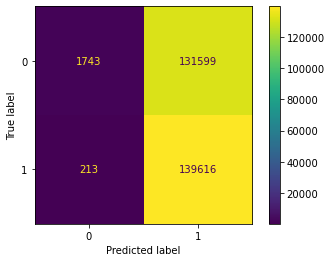

In [ ]:
ConfusionMatrixDisplay.from_predictions(knn_expected, knn_predicted)
plt.show()

### Decision Tree

In [89]:
parameters = { 
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2,4,5,6,7,8,9,10], 
    'min_samples_leaf':[2,4,6,8,10]
}
dt = DecisionTreeClassifier();
dt_start_time = datetime.now()
print('Start learning at {}'.format(str(dt_start_time)))
grid_dt = GridSearchCV(estimator=dt, param_grid=parameters, verbose=0);
grid_dt.fit(X_train, y_train);
dt_end_time = datetime.now() 
print('Stop learning {}'.format(str(dt_end_time)))
dt_elapsed_time= dt_end_time - dt_start_time
print('Elapsed learning {}'.format(str(dt_elapsed_time)))

Start learning at 2023-11-06 18:13:08.616050


c:\Users\soumy\anaconda3\Lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.

c:\Users\soumy\anaconda3\Lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.

c:\Users\soumy\anaconda3\Lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.

c:\Users\soumy\anaconda3\Lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.

c:\Users\soumy\anaconda3\Lib\site-packages\sklearn\tree\_classes.py:

Stop learning 2023-11-06 18:28:12.321487
Elapsed learning 0:15:03.705437


In [90]:
print(grid_dt.best_params_)
print(grid_dt.best_score_)
print(grid_dt.best_estimator_)

{'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2}
0.6153341994703453
DecisionTreeClassifier(max_features='log2', min_samples_leaf=2)


In [91]:
grid_dt.best_estimator_.fit(X_train, y_train);

In [92]:
dt_expected = y_test
dt_start_time_test = datetime.now()
print('Start testing at {}'.format(str(dt_start_time_test)))
dt_predicted = grid_dt.best_estimator_.predict(X_test)
dt_end_time_test = datetime.now() 
print('Stop testing {}'.format(str(dt_end_time_test)))
dt_elapsed_time_test = dt_end_time_test - dt_start_time_test
print('Elapsed testing {}'.format(str(dt_elapsed_time_test)))
dt_cm = metrics.confusion_matrix(dt_expected, dt_predicted)

Start testing at 2023-11-06 18:28:14.590854
Stop testing 2023-11-06 18:28:14.650967
Elapsed testing 0:00:00.060113


In [93]:
print("Accuracy={}".format(metrics.accuracy_score(dt_expected, dt_predicted)))
print("Classification report for classifier %s:\n%s\n"
      % ("Logistic Regression", metrics.classification_report(dt_expected, dt_predicted)))
print("Confusion matrix:\n%s" % dt_cm)

Accuracy=0.6440329620857719


Classification report for classifier Logistic Regression:
              precision    recall  f1-score   support

           0       0.59      0.70      0.64     13836
           1       0.38      0.41      0.40      4848
           2       0.58      0.53      0.55     10149
           3       0.81      0.77      0.79     19294
           4       0.52      0.34      0.41      2962

    accuracy                           0.64     51089
   macro avg       0.58      0.55      0.56     51089
weighted avg       0.65      0.64      0.64     51089


Confusion matrix:
[[ 9642  1273  1426  1298   197]
 [ 1662  1971   776   375    64]
 [ 2411  1116  5414   973   235]
 [ 2152   556  1286 14856   444]
 [  482   204   473   783  1020]]


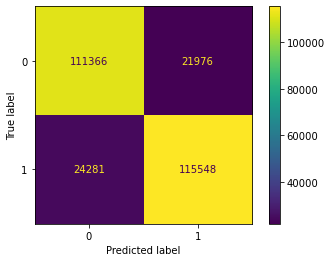

In [ ]:
ConfusionMatrixDisplay.from_predictions(dt_expected, dt_predicted)
plt.show()

### XG-Boost

In [19]:
parameters = { 
    'max_depth' : [10],
    'n_estimators': [100,200],
    'booster': ['gbtree']
}
xgb = XGBClassifier();
xgb_start_time = datetime.now()
print('Start learning at {}'.format(str(xgb_start_time)))
grid_xgb = GridSearchCV(estimator=xgb, param_grid=parameters, verbose=0);
grid_xgb.fit(X_train, y_train);
xgb_end_time = datetime.now() 
print('Stop learning {}'.format(str(xgb_end_time)))
xgb_elapsed_time= xgb_end_time - xgb_start_time
print('Elapsed learning {}'.format(str(xgb_elapsed_time)))

Start learning at 2023-11-13 22:55:28.598516


Stop learning 2023-11-13 22:57:49.618636
Elapsed learning 0:02:21.020120


In [20]:
print(grid_xgb.best_params_)
print(grid_xgb.best_score_)
print(grid_xgb.best_estimator_)

{'booster': 'gbtree', 'max_depth': 10, 'n_estimators': 200}
0.8117301016149945
XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)


In [21]:
grid_xgb.best_estimator_.fit(X_train2, y_train);

In [22]:
xgb = XGBClassifier(n_estimators=200,max_depth=10,booster='gbtree');
xgb.fit(X_train2, y_train);
xgb_expected = y_test
xgb_predicted = xgb.predict(X_test2)
xgb_cm = metrics.confusion_matrix(xgb_expected, xgb_predicted)

In [23]:
xgb_expected = y_test
xgb_start_time_test = datetime.now()
print('Start testing at {}'.format(str(xgb_start_time_test)))
xgb_predicted = xgb.predict(X_test2)
xgb_end_time_test = datetime.now() 
print('Stop testing {}'.format(str(xgb_end_time_test)))
xgb_elapsed_time_test = xgb_end_time_test - xgb_start_time_test
print('Elapsed testing {}'.format(str(xgb_elapsed_time_test)))
xgb_cm = metrics.confusion_matrix(xgb_expected, xgb_predicted)

Start testing at 2023-11-13 22:58:28.067681


Stop testing 2023-11-13 22:58:28.507675
Elapsed testing 0:00:00.439994


In [24]:
print("Accuracy={}".format(metrics.accuracy_score(xgb_expected, xgb_predicted)))
print("Classification report for classifier %s:\n%s\n"
      % ("XG-Boost", metrics.classification_report(xgb_expected, xgb_predicted)))
print("Confusion matrix:\n%s" % xgb_cm)

Accuracy=0.826798113322132
Classification report for classifier XG-Boost:
              precision    recall  f1-score   support

           0       0.75      0.84      0.79     10960
           1       0.78      0.60      0.68      5265
           2       0.80      0.75      0.77      9330
           3       0.89      0.93      0.91     18322
           4       0.87      0.79      0.83      5522

    accuracy                           0.83     49399
   macro avg       0.82      0.78      0.80     49399
weighted avg       0.83      0.83      0.82     49399


Confusion matrix:
[[ 9220   439   621   572   108]
 [ 1264  3185   605   163    48]
 [ 1105   350  7014   701   160]
 [  566    66   277 17077   336]
 [  180    33   280   682  4347]]


<Figure size 1800x1200 with 0 Axes>

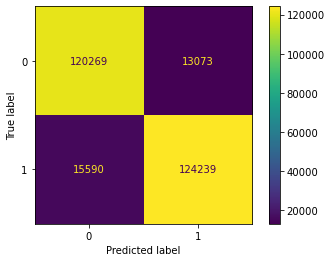

In [ ]:
plt.figure(dpi=300)
ConfusionMatrixDisplay.from_predictions(xgb_expected, xgb_predicted)
plt.show()

## 3. Testing

In [40]:
Test = np.array([[6,41.876248,-87.653065,50]])
Test2 = scaler.transform(Test)
print(xgb.predict(Test2)[0])
print(xgb.predict_proba(Test2))

4
[[0.35204846 0.05295288 0.03209766 0.00195467 0.56094635]]


In [ ]:
print(grid_xgb.best_estimator_.predict(X_test))

[0 0 1 ... 0 0 1]


In [ ]:
Test = np.array([[ 21, 0, 42.0122934 , -87.69971411, 15, 9]])
print(scaler.transform(Test))
Test2 = np.array([[-0.50714446,  0.70064672,  1.33995114, -1.07622397, -1.12694646, -0.47388072]])
scaler.transform(Test2)
print(xgb.predict(Test2))
print(xgb.predict_proba(Test2))

[[ 0.61286694 -1.94729926  2.0722281  -0.49585716 -0.35029065  0.79757858]]
[1]
[[7.1525574e-05 9.9992847e-01]]


In [ ]:
Test = np.array([[ 21, 0, 42.0122934, -87.69971411, 15, 9]])
print(xgb.predict_proba(scaler.transform(Test)))

[[0.86673784 0.13326216]]


In [25]:
pickle.dump(xgb, open('./xgboost.pkl', 'wb'))